# Event log enrichment 

In [89]:
### IMPORT ###
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


### LOCAL IMPORT ###
from config import config_reader

In [90]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")
# print(yaml_config) # debug
log_dir = str(yaml_config["LOG_DIR"])
data_dir = str(yaml_config["DATA_DIR"]) # directory with survey and other data
csv_sep = ";"

# INPUT
level = "PAGE" # PARA, PAGE
log_file_name = f"edu_event_log_{level}_raw_filtered_DISCO_ter.csv" # Set the file name
field_notes = "field_notes.csv"

id_column = "Case ID"
activity_column = "Activity"
timestamp_column = "Complete Timestamp"

# FUNCTIONS

In [91]:
def count_backward_jumps(activities: list) -> int:
    """
    Counts the number of backward jumps in a list of activities for a given case.

    A backward jump occurs when an activity is revisited after it has already been encountered.
    This function iterates through a sequence of activities and counts each instance
    where an activity has been previously seen.

    Args:
        activities (List[str]): A list of activity names (strings) for a single case,
                                in chronological order.

    Returns:
        int: The total number of backward jumps within the provided sequence of activities.
    """
    seen_activities: Set[str] = set()
    backward_jumps: int = 0
    
    for activity in activities:
        if activity in seen_activities:
            backward_jumps += 1
        seen_activities.add(activity)
    
    return backward_jumps

In [92]:
def count_forward_jumps(activities: list) -> int:
    """
    Counts the number of forward jumps in a list of activities for a given case.

    A forward jump occurs when an activity is encountered for the first time 
    and it appears later in the sequence. This function iterates through a 
    sequence of activities and counts each instance where an activity has 
    not been previously seen and appears in a forward position.

    Args:
        activities (List[str]): A list of activity names (strings) for a single case,
                                in chronological order.

    Returns:
        int: The total number of forward jumps within the provided sequence of activities.
    """
    seen_activities: Set[str] = set()
    forward_jumps: int = 0

    for i, activity in enumerate(activities):
        # Check if the activity appears later in the sequence and hasn't been seen before
        if activity not in seen_activities and activity in activities[i+1:]:
            forward_jumps += 1
        # Mark the activity as seen
        seen_activities.add(activity)
    
    return forward_jumps

# MAIN

In [93]:
print(">> Setings")
print("Input event log file:", log_file_name)
path_log_file = Path(log_dir) /log_file_name 
print("Path file:", path_log_file)

>> Setings
Input event log file: edu_event_log_PAGE_raw_filtered_DISCO_ter.csv
Path file: data_log/edu_event_log_PAGE_raw_filtered_DISCO_ter.csv


In [94]:
print(">> Reading event log")
dic_t = {'Case ID':object, 'CaseLength':int, 'SUS_Tercile':int, 'Apprendimento percepito_Tercile':int, 'UEQ - Overall_Tercile':int} 
df_log = pd.read_csv(path_log_file, sep=csv_sep, dtype=dic_t) # initial event log

>> Reading event log


In [95]:
print(">> Removing columns from event log of DISCO")
col_del_list = ['Variant', 'Variant index']
print(col_del_list)
for col_del in col_del_list:
  if col_del in df_log.columns:
    print("Removig column:", col_del)
    df_log.drop(columns=col_del, inplace=True)

>> Removing columns from event log of DISCO
['Variant', 'Variant index']


In [96]:
df_log.columns

Index(['Case ID', 'pageTitle', 'Activity', 'menu', 'pageOrder', 'pagePara',
       'eventPage', 'Complete Timestamp', 'click_num', 'dbclick_num',
       'QuizSessionCount', 'QuizAnswerCorrectTotal', 'QuizAnswerWrongTotal',
       'QuizAnswerCorrectRatioOverCount', 'QuizAnswerCorrectRatioOverAll',
       'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8', 'Q_9', 'Q_10',
       'Q_11', 'Q_12', 'Q_13', 'Q_14', 'Q_15', 'Q_16', 'Q_17', 'Q_18', 'Q_19',
       'Q_20', 'Q_21', 'Q_22', 'Q_23', 'Q_24', 'Q_25', 'Q_26', 'Q_27', 'Q_28',
       'SUS', 'Apprendimento percepito', 'UEQ - Pragmatic', 'UEQ - Hedonic',
       'UEQ - Overall', 'TotalTimeHH', 'TotalTimeMM', 'TotalTimeDD',
       'CaseLength', 'Class', 'SUS_Tercile', 'Apprendimento percepito_Tercile',
       'UEQ - Overall_Tercile', 'QuizAnswerCorrectRatioOverAll_Tercile'],
      dtype='object')

In [97]:
# if level == "PARA":
  #   df_log = df_log.drop(columns=['Activity']).rename(columns={'eventPara': 'Activity'})
# elif level == "PAGE":
  #  pass

In [98]:
# Rearranges dataframe columns
ordered_columns = [id_column, activity_column, timestamp_column] + [col for col in df_log.columns if col not in [id_column, activity_column, timestamp_column]]
df_log = df_log[ordered_columns]

In [99]:
df_log.shape

(8092, 57)

In [100]:
print("Distinct cases in event log:", df_log[id_column].nunique())

Distinct cases in event log: 332


In [101]:
# PARA event log
print("Distinct activities in event log:", df_log[activity_column].nunique())

Distinct activities in event log: 22


In [102]:
df_log.head(5)

,Case ID,Activity,Complete Timestamp,pageTitle,menu,pageOrder,pagePara,eventPage,click_num,dbclick_num,...,UEQ - Overall,TotalTimeHH,TotalTimeMM,TotalTimeDD,CaseLength,Class,SUS_Tercile,Apprendimento percepito_Tercile,UEQ - Overall_Tercile,QuizAnswerCorrectRatioOverAll_Tercile
0,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,SURVEY-END,2024-04-22 13:50:32,SURVEY-END,menu_1,1,0,PageIN,1,0,...,-1.0,0.92,55.5,0.04,22,SMCN1,1,1,1,2
1,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO,2024-04-22 14:11:42,INTRO,menu_1,1,0,PageIN,1,0,...,-1.0,0.92,55.5,0.04,22,SMCN2,1,1,1,2
2,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO-Q,2024-04-22 14:20:32,INTRO-Q,menu_1,1,0,PageIN,1,0,...,-1.0,0.92,55.5,0.04,22,SMCN2,1,1,1,2
3,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG,2024-04-22 14:21:04,PROG,menu_1,2,0,PageIN,1,0,...,-1.0,0.92,55.5,0.04,22,SMCN2,1,1,1,2
4,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG-Q,2024-04-22 14:24:57,PROG-Q,menu_1,2,0,PageIN,1,0,...,-1.0,0.92,55.5,0.04,22,SMCN2,1,1,1,2


In [103]:
df_log.columns

Index(['Case ID', 'Activity', 'Complete Timestamp', 'pageTitle', 'menu',
       'pageOrder', 'pagePara', 'eventPage', 'click_num', 'dbclick_num',
       'QuizSessionCount', 'QuizAnswerCorrectTotal', 'QuizAnswerWrongTotal',
       'QuizAnswerCorrectRatioOverCount', 'QuizAnswerCorrectRatioOverAll',
       'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8', 'Q_9', 'Q_10',
       'Q_11', 'Q_12', 'Q_13', 'Q_14', 'Q_15', 'Q_16', 'Q_17', 'Q_18', 'Q_19',
       'Q_20', 'Q_21', 'Q_22', 'Q_23', 'Q_24', 'Q_25', 'Q_26', 'Q_27', 'Q_28',
       'SUS', 'Apprendimento percepito', 'UEQ - Pragmatic', 'UEQ - Hedonic',
       'UEQ - Overall', 'TotalTimeHH', 'TotalTimeMM', 'TotalTimeDD',
       'CaseLength', 'Class', 'SUS_Tercile', 'Apprendimento percepito_Tercile',
       'UEQ - Overall_Tercile', 'QuizAnswerCorrectRatioOverAll_Tercile'],
      dtype='object')

In [104]:
null_counts = df_log.isnull().sum()
null_counts

Case ID                                   0
Activity                                  0
Complete Timestamp                        0
pageTitle                                 0
menu                                      0
pageOrder                                 0
pagePara                                  0
eventPage                                 0
click_num                                 0
dbclick_num                               0
QuizSessionCount                          0
QuizAnswerCorrectTotal                    0
QuizAnswerWrongTotal                      0
QuizAnswerCorrectRatioOverCount          11
QuizAnswerCorrectRatioOverAll            11
Q_1                                       0
Q_2                                       0
Q_3                                       0
Q_4                                       0
Q_5                                       0
Q_6                                       0
Q_7                                       0
Q_8                             

In [105]:
# Checking shape before enrichment
df_log.shape

(8092, 57)

## Merging event log with new features

In [106]:
# Creating a copy of the original df_log
df_log_enr = df_log.copy()
df_log_enr.shape

(8092, 57)

### Adding total minutes columns

In [107]:
df_log_enr['TotalTimeMM'] = (df_log_enr['TotalTimeHH'] * 60).round(2)

In [108]:
# Identifying the position of "TotalTimeHH" in the dataframe to insert "TotalTimeMM" right after it
cols_before = df_log_enr.columns[:df_log_enr.columns.get_loc("TotalTimeHH")].tolist()  # Columns before "TotalTimeHH"
cols_after = df_log_enr.columns[df_log_enr.columns.get_loc("TotalTimeHH") + 1:].tolist()  # Columns after "TotalTimeHH"

# New order: cols_before + "TotalTimeHH" + "TotalTimeMM" + cols_after
ordered_columns = cols_before + ["TotalTimeHH", "TotalTimeMM"] + cols_after
df_log_enr = df_log_enr[ordered_columns]


In [109]:
df_log_enr.head()

,Case ID,Activity,Complete Timestamp,pageTitle,menu,pageOrder,pagePara,eventPage,click_num,dbclick_num,...,TotalTimeHH,TotalTimeMM,TotalTimeMM,TotalTimeDD,CaseLength,Class,SUS_Tercile,Apprendimento percepito_Tercile,UEQ - Overall_Tercile,QuizAnswerCorrectRatioOverAll_Tercile
0,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,SURVEY-END,2024-04-22 13:50:32,SURVEY-END,menu_1,1,0,PageIN,1,0,...,0.92,55.2,55.2,0.04,22,SMCN1,1,1,1,2
1,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO,2024-04-22 14:11:42,INTRO,menu_1,1,0,PageIN,1,0,...,0.92,55.2,55.2,0.04,22,SMCN2,1,1,1,2
2,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO-Q,2024-04-22 14:20:32,INTRO-Q,menu_1,1,0,PageIN,1,0,...,0.92,55.2,55.2,0.04,22,SMCN2,1,1,1,2
3,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG,2024-04-22 14:21:04,PROG,menu_1,2,0,PageIN,1,0,...,0.92,55.2,55.2,0.04,22,SMCN2,1,1,1,2
4,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG-Q,2024-04-22 14:24:57,PROG-Q,menu_1,2,0,PageIN,1,0,...,0.92,55.2,55.2,0.04,22,SMCN2,1,1,1,2


### Class cardinality

In [110]:
print(">> Adding class cardinality")
df_log_enr["Class"].unique()

>> Adding class cardinality


array(['SMCN1', 'SMCN2', 'SAA', 'ECO', 'SMTO1', nan, 'SMTO2', 'SMTO3'],
      dtype=object)

In [111]:
# Calculate the count (numerosity) of each unique value in the "Class" column
distinct_class_counts = df_log_enr[['Class', id_column]].drop_duplicates().groupby('Class').size().to_dict()
distinct_class_counts

{'ECO': 125,
 'SAA': 97,
 'SMCN1': 38,
 'SMCN2': 26,
 'SMTO1': 33,
 'SMTO2': 25,
 'SMTO3': 18}

In [112]:
total_distinct_class_counts = sum(distinct_class_counts.values())
print("Total of class:", total_distinct_class_counts)

Total of class: 362


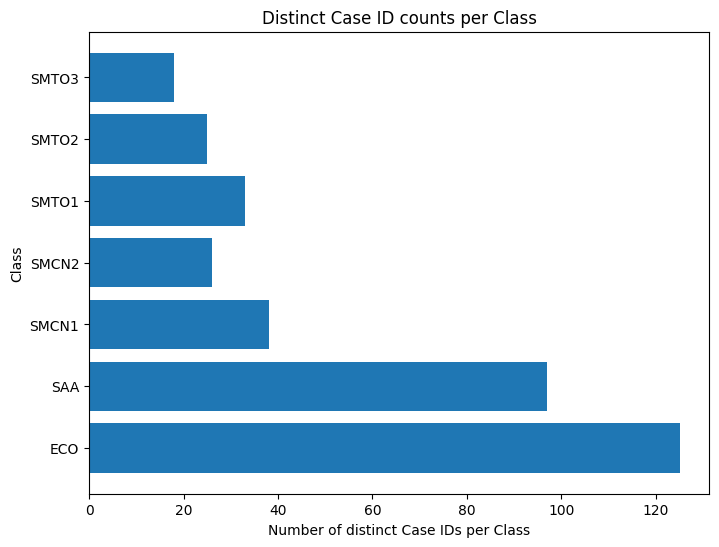

In [113]:
# Plotting a horizontal bar chart for the distinct class counts
plt.figure(figsize=(8, 6))
plt.barh(list(distinct_class_counts.keys()), list(distinct_class_counts.values()))
plt.xlabel("Number of distinct Case IDs per Class")
plt.ylabel("Class")
plt.title("Distinct Case ID counts per Class")
plt.show()

In [114]:
# Step 2: Map the calculated counts back to the df_log_enr based on the "Class" values
df_log_enr['Class_Count'] = df_log_enr['Class'].map(distinct_class_counts)

In [115]:
df_log_enr.head(5)

,Case ID,Activity,Complete Timestamp,pageTitle,menu,pageOrder,pagePara,eventPage,click_num,dbclick_num,...,TotalTimeMM,TotalTimeMM,TotalTimeDD,CaseLength,Class,SUS_Tercile,Apprendimento percepito_Tercile,UEQ - Overall_Tercile,QuizAnswerCorrectRatioOverAll_Tercile,Class_Count
0,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,SURVEY-END,2024-04-22 13:50:32,SURVEY-END,menu_1,1,0,PageIN,1,0,...,55.2,55.2,0.04,22,SMCN1,1,1,1,2,38.0
1,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO,2024-04-22 14:11:42,INTRO,menu_1,1,0,PageIN,1,0,...,55.2,55.2,0.04,22,SMCN2,1,1,1,2,26.0
2,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO-Q,2024-04-22 14:20:32,INTRO-Q,menu_1,1,0,PageIN,1,0,...,55.2,55.2,0.04,22,SMCN2,1,1,1,2,26.0
3,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG,2024-04-22 14:21:04,PROG,menu_1,2,0,PageIN,1,0,...,55.2,55.2,0.04,22,SMCN2,1,1,1,2,26.0
4,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG-Q,2024-04-22 14:24:57,PROG-Q,menu_1,2,0,PageIN,1,0,...,55.2,55.2,0.04,22,SMCN2,1,1,1,2,26.0


In [116]:
df_log_enr.shape

(8092, 59)

### Field notes

In [117]:
print(">> Adding field notes")
path_notes = Path(data_dir) / field_notes
print("Path:", path_notes)
dic_t = {"Class":object, "FN_N":int, "FN_Q":int, "FN_A":int, "FN_C":int, "FN_I":int, "FN_CT":object}
df_notes = pd.read_csv(path_notes, sep=";", dtype=dic_t)

>> Adding field notes
Path: data/field_notes.csv


In [118]:
df_notes.head()

,Class,FN_N,FN_Q,FN_A,FN_C,FN_I,FN_CT
0,SAA,1,1,0,1,1,FA
1,ECO,0,0,1,0,1,SA
2,SMTO1,1,1,0,1,1,M
3,SMTO2,0,0,0,0,0,L
4,SMTO3,1,0,0,0,1,FA


In [119]:
# Merge df_notes into df_log_enr on 'Class', adding the columns from df_notes to df_log_enr
df_log_enr = df_log_enr.merge(df_notes, on='Class', how='left')

In [120]:
df_log_enr.head(5)

,Case ID,Activity,Complete Timestamp,pageTitle,menu,pageOrder,pagePara,eventPage,click_num,dbclick_num,...,Apprendimento percepito_Tercile,UEQ - Overall_Tercile,QuizAnswerCorrectRatioOverAll_Tercile,Class_Count,FN_N,FN_Q,FN_A,FN_C,FN_I,FN_CT
0,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,SURVEY-END,2024-04-22 13:50:32,SURVEY-END,menu_1,1,0,PageIN,1,0,...,1,1,2,38.0,0.0,0.0,0.0,0.0,0.0,L
1,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO,2024-04-22 14:11:42,INTRO,menu_1,1,0,PageIN,1,0,...,1,1,2,26.0,0.0,0.0,1.0,1.0,0.0,FA
2,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO-Q,2024-04-22 14:20:32,INTRO-Q,menu_1,1,0,PageIN,1,0,...,1,1,2,26.0,0.0,0.0,1.0,1.0,0.0,FA
3,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG,2024-04-22 14:21:04,PROG,menu_1,2,0,PageIN,1,0,...,1,1,2,26.0,0.0,0.0,1.0,1.0,0.0,FA
4,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG-Q,2024-04-22 14:24:57,PROG-Q,menu_1,2,0,PageIN,1,0,...,1,1,2,26.0,0.0,0.0,1.0,1.0,0.0,FA


In [121]:
df_log_enr.shape

(8092, 65)

### Activity duration

In [122]:
# Convert the timestamp_column column to datetime format for time calculations
df_log_enr[timestamp_column] = pd.to_datetime(df_log_enr[timestamp_column])

# Sort by 'Case ID' and timestamp_column to ensure activities are in chronological order within each case
df_log_enr = df_log_enr.sort_values(by=[id_column, timestamp_column])

# Shift the timestamp_column column within each 'Case ID' to get the timestamp of the next activity
df_log_enr['Next_Timestamp'] = df_log_enr.groupby('Case ID')[timestamp_column].shift(-1)

# Calculate the time difference in seconds and minutes between the current activity and the next activity
df_log_enr['A_Time_s'] = (df_log_enr['Next_Timestamp'] - df_log_enr[timestamp_column]).dt.total_seconds()
df_log_enr['A_Time_m'] = df_log_enr['A_Time_s'] / 60

# Fill NaN values with 0 for the last activity in each case (as there's no next activity to calculate a time difference)
df_log_enr[['A_Time_s', 'A_Time_m']] = df_log_enr[['A_Time_s', 'A_Time_m']].fillna(0)

# Round the 'Activity_Time_s' and 'A_Time_m' columns to two decimal places
df_log_enr['A_Time_s'] = df_log_enr['A_Time_s'].round(2)
df_log_enr['A_Time_m'] = df_log_enr['A_Time_m'].round(2)

# Drop the temporary 'Next_Timestamp' column as it's no longer needed
df_log_enr = df_log_enr.drop(columns=['Next_Timestamp'])

In [123]:
df_log_enr.head(5)

,Case ID,Activity,Complete Timestamp,pageTitle,menu,pageOrder,pagePara,eventPage,click_num,dbclick_num,...,QuizAnswerCorrectRatioOverAll_Tercile,Class_Count,FN_N,FN_Q,FN_A,FN_C,FN_I,FN_CT,A_Time_s,A_Time_m
0,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,SURVEY-END,2024-04-22 13:50:32,SURVEY-END,menu_1,1,0,PageIN,1,0,...,2,38.0,0.0,0.0,0.0,0.0,0.0,L,1270.0,21.17
1,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO,2024-04-22 14:11:42,INTRO,menu_1,1,0,PageIN,1,0,...,2,26.0,0.0,0.0,1.0,1.0,0.0,FA,530.0,8.83
2,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO-Q,2024-04-22 14:20:32,INTRO-Q,menu_1,1,0,PageIN,1,0,...,2,26.0,0.0,0.0,1.0,1.0,0.0,FA,32.0,0.53
3,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG,2024-04-22 14:21:04,PROG,menu_1,2,0,PageIN,1,0,...,2,26.0,0.0,0.0,1.0,1.0,0.0,FA,233.0,3.88
4,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG-Q,2024-04-22 14:24:57,PROG-Q,menu_1,2,0,PageIN,1,0,...,2,26.0,0.0,0.0,1.0,1.0,0.0,FA,17.0,0.28


In [124]:
df_log_enr.shape

(8092, 67)

### Backward / Forward jumps

In [125]:
# Convert the 'Complete Timestamp' column to datetime format
df_log_enr['Complete Timestamp'] = pd.to_datetime(df_log_enr['Complete Timestamp'])

# Sort by 'Case ID' and 'Complete Timestamp' for chronological order within each case
df_log_enr = df_log_enr.sort_values(by=['Case ID', 'Complete Timestamp'])

# Apply the function to count backward jumps for each 'Case ID' and add the result as a new column
df_log_enr['Backward_Jumps'] = df_log_enr.groupby('Case ID')[activity_column].transform(count_backward_jumps)

# Apply the function to count forward jumps for each 'Case ID' and add the result as a new column
# df_log_enr['Forward_Jumps'] = df_log_enr.groupby('Case ID')['Activity'].transform(count_forward_jumps)

In [126]:
df_log_enr.head(5)

,Case ID,Activity,Complete Timestamp,pageTitle,menu,pageOrder,pagePara,eventPage,click_num,dbclick_num,...,Class_Count,FN_N,FN_Q,FN_A,FN_C,FN_I,FN_CT,A_Time_s,A_Time_m,Backward_Jumps
0,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,SURVEY-END,2024-04-22 13:50:32,SURVEY-END,menu_1,1,0,PageIN,1,0,...,38.0,0.0,0.0,0.0,0.0,0.0,L,1270.0,21.17,0
1,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO,2024-04-22 14:11:42,INTRO,menu_1,1,0,PageIN,1,0,...,26.0,0.0,0.0,1.0,1.0,0.0,FA,530.0,8.83,0
2,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,INTRO-Q,2024-04-22 14:20:32,INTRO-Q,menu_1,1,0,PageIN,1,0,...,26.0,0.0,0.0,1.0,1.0,0.0,FA,32.0,0.53,0
3,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG,2024-04-22 14:21:04,PROG,menu_1,2,0,PageIN,1,0,...,26.0,0.0,0.0,1.0,1.0,0.0,FA,233.0,3.88,0
4,0HcsM5K14bTga4CpYETnQuMBKMrDBCQgHeGk48sRul6Pha...,PROG-Q,2024-04-22 14:24:57,PROG-Q,menu_1,2,0,PageIN,1,0,...,26.0,0.0,0.0,1.0,1.0,0.0,FA,17.0,0.28,0


In [127]:
# Checking shape after enrichments
df_log_enr.shape

(8092, 68)

## Saving event log enriched

In [128]:
print(">> Saving enriched event log")
log_file_name_enr = f"{Path(log_file_name).stem}_enr.csv"
path_log_file = Path(log_dir) / log_file_name_enr 
print("Path:", path_log_file)
df_log_enr.to_csv(path_log_file, sep = ",", index=False)

>> Saving enriched event log
Path: data_log/edu_event_log_PAGE_raw_filtered_DISCO_ter_enr.csv
